# RestNetActivations and Fully Connected layers - 0.3m

In [0]:
BASE_RES = 0.3
BASE_RES_NAME = "0.3"

## Imports

In [2]:
pip install python-dotenv

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

import gc
import numpy as np
import pandas as pd
import sys
import os
import datetime
import math
import time
from tqdm import tqdm_notebook as tqdm

from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers
from keras import backend as K

Using TensorFlow backend.


In [4]:
try: # if running on COLAB
    
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')
    PATH = '/content/drive/My Drive/Colab/MasterThesis/'
    #PATH_IMG = "/content/drive/My Drive/MFP - Satellogic/images/"
    #PATH_IMG = "/content/drive/My Drive/MDS/MFP - Satellogic/images/"
    
    # confirm GPU is available
    device_name = tf.test.gpu_device_name()
    #if device_name != '/device:GPU:0':
    #    raise SystemError('GPU device not found')

except:
    from dotenv import load_dotenv
    sys.path.append("../Library/")
    import image_manipulation as ima
    PATH = os.path.join(os.getenv('GDRIVE_FOLDER'), 'Colab/MasterThesis')
    #PATH_IMG = os.path.join(os.getenv('GDRIVE_FOLDER'), 'MFP - Satellogic/images/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
PATH_DATA = os.path.join(PATH, 'Data/')
PATH_DATA_RES = os.path.join(PATH_DATA, BASE_RES_NAME + 'm/')

PATH_MOD = os.path.join(PATH, 'Models/')
PATH_MOD_RES = os.path.join(PATH_MOD, BASE_RES_NAME + 'm/')

PATH_RESULTS = os.path.join(PATH, "Results/")
PATH_RESULTS_RES = os.path.join(PATH_RESULTS, BASE_RES_NAME + 'm/')

PATH_HISTORY = os.path.join(PATH, "History/")
PATH_HISTORY_RES = os.path.join(PATH_HISTORY, BASE_RES_NAME + 'm/')

PATH_LIB = os.path.join(PATH, 'Library/')
PATH_NOTE = os.path.join(PATH, 'Notebooks/')
sys.path.append(PATH_LIB)

print("Folders content:")
print("PATH:\t\t", os.listdir(PATH))
print("PATH DATA:\t", os.listdir(PATH_DATA))
print("PATH DATA_RES:\t", os.listdir(PATH_DATA_RES))
print("PATH MODELS:\t", os.listdir(PATH_MOD))
print("PATH MODELS_RES:\t", os.listdir(PATH_MOD_RES))
print("PATH RESULTS:\t", os.listdir(PATH_RESULTS))
print("PATH RESULTS_RES:\t", os.listdir(PATH_RESULTS_RES))
print("PATH HISTORY:\t", os.listdir(PATH_HISTORY))
print("PATH HISTORY_RES:\t", os.listdir(PATH_HISTORY_RES))
print("PATH LIBRARY:\t", os.listdir(PATH_LIB))
print("PATH NOTEBOOKS:\t", os.listdir(PATH_NOTE))
#print("PATH IMAGES:\t", os.listdir(PATH_IMG))

Folders content:
PATH:		 ['Notebooks', '.env', 'Library', 'Data', 'Models', 'Results_0.3m_excl_label1', 'Results_1m_excl_label1', 'Results_0.3-1m_excl_label1', 'Results', 'History']
PATH DATA:	 ['1m', '0.3-1m', '0.3m']
PATH DATA_RES:	 ['categories_images_res0.3.npy', 'X_images_res0.3.npy', 'filenames_images_res0.3.npy', 'y_images_res0.3.npy', 'X_act_res0.6.npy', 'X_act_res0.9.npy', 'X_act_res1.2.npy', 'X_act_res1.5.npy', 'X_act_res1.8.npy', 'X_act_res2.1.npy', 'X_act_res2.4.npy', 'X_act_res2.7.npy', 'X_act_res3.0.npy', 'X_act_res3.3.npy', 'X_act_res3.6.npy', 'X_act_res3.9.npy', 'X_act_res4.2.npy', 'X_act_res4.5.npy', 'X_act_res4.8.npy']
PATH MODELS:	 ['1m_200n', '0.3m_200n', '0.3m']
PATH MODELS_RES:	 []
PATH RESULTS:	 ['0.3m_100n', '1m_100n', '1m_200n', '0.3m_200n', '0.3m']
PATH RESULTS_RES:	 []
PATH HISTORY:	 ['0.3m_200n', '1m_100n', '1m_200n', '0.3m_100n', '0.3m']
PATH HISTORY_RES:	 []
PATH LIBRARY:	 ['__pycache__', 'IO.py', 'db_connection.py', 'machine_learning.py', 'generate_datase

In [0]:
%load_ext autoreload
%autoreload 2
import deep_learning as dl
import image_manipulation as ima
import machine_learning as ml

## Functions

In [0]:
def get_activations(img, base_model, activation = 1, print_ = False):
    """
    Returns ReLUs of layer specified by parameter activation

    :param img: np.array
    :param base_model: Keras Model
    :param activation_: int
    :return:
    """
    if not isinstance(img, np.ndarray):
        img = np.array(img)

    if len(img.shape) == 3:
        img = np.expand_dims(img, axis=0)

    img = preprocess_input(img)
    if print_: print("Shape of input:", img.shape)
    
    model = Model(inputs=base_model.input,
                  outputs=base_model.get_layer('activation_' + str(activation)).output)

    activation = model.predict(img)
    if print_: print("Shape of output:", activation.shape)
        
    del model, img
    gc.collect()
    
    return activation
  
def remove_specific_label(X, y, label = 1):
    not_label = y != label
    return X[not_label], y[not_label]
  
def intialize_train(X_train, y_train, X_val, y_val, params):
    
    dim = params['dim']
    neurons = params.pop('neurons', 512)
    batch_size = params.pop('batch_size', 20)
    epochs = params.pop('epochs', 20)
    learning_rate = params.pop('lr', 2e-5)
    
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_dim= dim[1] * dim[2] * dim[3], kernel_initializer='random_uniform'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=params.pop('callbacks', [])
                       )
    
    return history, model
  
def get_indices_of_wrong_classified_images(X, y, test_indices, model):
    test_idx_wrong_classified = model.predict_classes(X).flatten() != y
    img_wrong_classified = test_indices[test_idx_wrong_classified]
    return img_wrong_classified

  
    
import pickle

def save_obj(obj, fullpath):
    with open(fullpath + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(fullpath):
    with open(fullpath + '.pkl', 'rb') as f:
        return pickle.load(f)
      
        
def save_keras_model(model, path, fold, res):

    fullpath = os.path.join(path, 'model' + '_res' + str(res) + '_fold' + str(fold))
    
    # serialize model to JSON
    model_json = model.to_json()
    with open(fullpath + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(fullpath + ".h5")
    print("Saved model to disk")


def save_model_history(history, path, fold, res):
    fullpath = os.path.join(path, 'history' + '_res' + str(res) + '_fold' + str(fold))
    save_obj(history.history, fullpath) 

In [0]:
def print_time(string=''):
    print('', str(datetime.datetime.today())[:22], string)
    return

In [0]:
CATEGORIES = ["forest-woodland", "agriculture", "shrubland-grassland", "semi-desert"]

## Train complete network from source images

### Load Data

In [0]:
X_name = 'X_images_res' + BASE_RES_NAME + '.npy'
y_name = 'y_images_res' + BASE_RES_NAME + '.npy'
filenames_name = 'filenames_images_res' + BASE_RES_NAME + '.npy'
categories_name = 'categories_images_res' + BASE_RES_NAME + '.npy'

X_base, y = np.load(os.path.join(PATH_DATA_RES, X_name)), np.load(os.path.join(PATH_DATA_RES, y_name), allow_pickle = True)
filenames, categories = np.load(os.path.join(PATH_DATA_RES, filenames_name), allow_pickle = True), np.load(os.path.join(PATH_DATA_RES, categories_name), allow_pickle = True)

In [0]:
limit = 1500
X_base, y, filenames, categories = X_base[:limit], y[:limit], filenames[:limit], categories[:limit]

filename: 14skc100230_x132_y1156_size512_baseres0.3m.png
category: agriculture
label: 1


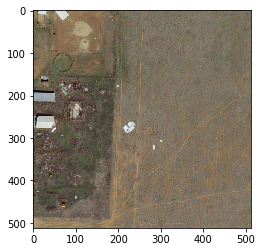

In [12]:
img = 0
print("filename:", filenames[img])
print("category:", categories[img])
print("label:", y[img])
plt.imshow(X_base[img])

### Parameters: Resolutions and Categories

In [13]:
base_res = BASE_RES
base_size = 512
N_RES = 17

sizes = {base_res: (base_size, base_size)}
for factor in range(2, N_RES):
    res = round(base_res * factor,1)
    size = round(base_size/factor)
    sizes[res] = (size, size)
print("Sizes dictionary:\n", sizes)

resolutions = [res for res in sizes]
resolutions.sort()
print("Resolutions:\n", resolutions)

Sizes dictionary:
 {0.3: (512, 512), 0.6: (256, 256), 0.9: (171, 171), 1.2: (128, 128), 1.5: (102, 102), 1.8: (85, 85), 2.1: (73, 73), 2.4: (64, 64), 2.7: (57, 57), 3.0: (51, 51), 3.3: (47, 47), 3.6: (43, 43), 3.9: (39, 39), 4.2: (37, 37), 4.5: (34, 34), 4.8: (32, 32)}
Resolutions:
 [0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3.0, 3.3, 3.6, 3.9, 4.2, 4.5, 4.8]


In [0]:
#stop here

### Load base NN model

Load ResNet and set all layers to `trainable = False` and list *activation* layers:

In [14]:
base_model = ResNet50(weights='imagenet', include_top=False)

activation_layers = []
for l in base_model.layers:
    l.trainable = False
    if "activation" in l.name or "relu" in l.name:
        activation_layers.append(l.name)
print(activation_layers)

W0627 15:53:55.185586 140661150750592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 15:53:55.188828 140661150750592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 15:53:55.197764 140661150750592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0627 15:53:55.234641 140661150750592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0627 15:53:55.235628

['activation_1', 'activation_2', 'activation_3', 'activation_4', 'activation_5', 'activation_6', 'activation_7', 'activation_8', 'activation_9', 'activation_10', 'activation_11', 'activation_12', 'activation_13', 'activation_14', 'activation_15', 'activation_16', 'activation_17', 'activation_18', 'activation_19', 'activation_20', 'activation_21', 'activation_22', 'activation_23', 'activation_24', 'activation_25', 'activation_26', 'activation_27', 'activation_28', 'activation_29', 'activation_30', 'activation_31', 'activation_32', 'activation_33', 'activation_34', 'activation_35', 'activation_36', 'activation_37', 'activation_38', 'activation_39', 'activation_40', 'activation_41', 'activation_42', 'activation_43', 'activation_44', 'activation_45', 'activation_46', 'activation_47', 'activation_48', 'activation_49']


In [0]:
#base_model.summary()

### Run DL pipeline for all resolutions

In [15]:
SAVE_MODEL = False
SAVE_RESULT = True
SAVE_HISTORY = True
RESOLUTIONS = resolutions[:1]


N_images = X_base.shape[0]
from sklearn.model_selection import StratifiedKFold

kFold = StratifiedKFold(n_splits=8, random_state = 40) #n_splits=8
batch_size_activations = 100
batch_size = 50
neurons = 100 #100 256
results = []

N_ACTIVATIONS = len(activation_layers)
act_layer = activation_layers[N_ACTIVATIONS-1]

for res in RESOLUTIONS:

    ## Activations and Preprocessing
    print("\n--- Getting Activations for resolution", res, "---\n")
    
    ## Load Activations from disk, if exist
    path_act = os.path.join(PATH_DATA_RES, 'X_act_res' + str(res) + '.npy')
    if os.path.exists(path_act):
        print("loading activations from disk...")
        X_act = np.load(path_act)
    else:
        ## Degrading and computing activations
        print("degrading...")
        X = np.array([ima.degrade_image(X_base[i], sizes[res]) for i in range(N_images)])
        if len(RESOLUTIONS) == 1: 
            del X_base
            gc.collect()
            print("X_base deleted...")
        
        print("computing activations...")
        
        #X_act = get_activations(X[0], base_model, int(activation_layers[-1].split("_")[-1]))
        #for i in tqdm(range(1, X.shape[0], batch_size_activations)):
        #    X_act = np.r_[X_act, get_activations(X[i:i+batch_size_activations], base_model, int(activation_layers[-1].split("_")[-1]))]
        
        #X_act = []
        #for i in tqdm(range(0, X.shape[0], batch_size_activations)):
        #    X_act.append(get_activations(X[i:i+batch_size_activations], base_model, int(activation_layers[-1].split("_")[-1])))
        #X_act = np.r_[X_act]
        #X_act = np.array(X_act)
        
        X_act = get_activations(X, base_model, int(activation_layers[-1].split("_")[-1]))
        
        del X
        gc.collect()
        time.sleep(5)
        
        #np.save(path_act, X_act)
    #break
    
    X_act = preprocess_input(X_act)

    ## Initialize parameters for CV
    params = {}
    fold = 0
    result_per_res = []
    
    ## Training with CV
    for train, val in kFold.split(X_act, y):
        
        print("\n ---- Processing fold", fold, "at resolution", res, "--- \n")
        
        #print(train)
        #print(val)
        #img = train[0]
        #print("filename:", filenames[img])
        #print("category:", categories[img])
        #print("label:", y[img])
        #plt.imshow(X_base[img])
        
        dim = X_act.shape
        X_train = np.reshape(X_act[train], (X_act[train].shape[0], dim[1] * dim[2] * dim[3]))
        X_val = np.reshape(X_act[val], (X_act[val].shape[0], dim[1] * dim[2] * dim[3]))
        y_train, y_val = y[train], y[val]
        
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                verbose=1,
                mode='auto',
                baseline=0.9,
            ),
            keras.callbacks.ModelCheckpoint(
                'model_res' + str(res) + '_fold' + str(fold) + '-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5',
                verbose=1, 
                monitor='val_loss',
                save_best_only=True, 
                mode='auto'
            )
        ]

        params['dim'] = dim
        params['batch_size'] = batch_size
        params['epochs'] = 30
        params['neurons'] = neurons
        #params['callbacks'] = callbacks
        
        print_time("training...")
        history, model = intialize_train(X_train, y_train, X_val, y_val, params)
        del X_train, y_train
        gc.collect()

        print_time("evaluating...")
        loss, acc = model.evaluate(X_val, y_val)
        print('Accuracy:', acc)
        
        # Get indices of wrongly classified images
        img_wrong_classified = get_indices_of_wrong_classified_images(X_val, y_val, val, model)
        
        result = {
            "wrong_class": img_wrong_classified.tolist(),
            "resolution": res,
            "accuracy": acc,
            "loss": loss,
            "fold": fold
        }
        
        for cat in CATEGORIES:
            val_cat_idx = categories[val] == cat
            X_val_cat = X_val[val_cat_idx]
            y_val_cat = y_val[val_cat_idx]
            loss, acc_cat = model.evaluate(X_val_cat, y_val_cat)
            result["accuracy_"+cat] = acc_cat
            print('Category:', cat, "Accuracy:", acc_cat) 
            
        result_per_res.append(result) 
        
        if SAVE_MODEL: save_keras_model(model, PATH_MOD_RES, fold, res)
        if SAVE_HISTORY: save_model_history(history, PATH_HISTORY_RES, fold, res)
        if SAVE_RESULT: pd.DataFrame(result_per_res).to_csv(os.path.join(PATH_RESULTS_RES, "result_res" + str(res) + ".csv"), index=False)
        
        del X_val, y_val, X_val_cat, y_val_cat, model, history
        gc.collect()
        
        fold += 1

del X_act
gc.collect()

print()
print_time("DONE! \n")   


--- Getting Activations for resolution 0.3 ---

degrading...
X_base deleted...
computing activations...

 ---- Processing fold 0 at resolution 0.3 --- 



W0627 15:55:14.429153 140661150750592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0627 15:55:14.439089 140661150750592 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 2019-06-27 15:55:14.39 training...
Train on 1312 samples, validate on 188 samples
Epoch 1/30
1312/1312 [==============================] - 7s 5ms/step - loss: 3.1319 - acc: 0.7165 - val_loss: 2.1840 - val_acc: 0.8245
Epoch 2/30
1312/1312 [==============================] - 3s 3ms/step - loss: 1.3743 - acc: 0.8689 - val_loss: 1.6169 - val_acc: 0.8617
Epoch 3/30
1312/1312 [==============================] - 3s 2ms/step - loss: 1.1379 - acc: 0.8834 - val_loss: 1.3091 - val_acc: 0.8723
Epoch 4/30
1312/1312 [==============================] - 3s 2ms/step - loss: 0.6668 - acc: 0.9299 - val_loss: 1.2454 - val_acc: 0.8883
Epoch 5/30
1312/1312 [==============================] - 3s 3ms/step - loss: 0.4673 - acc: 0.9451 - val_loss: 1.0225 - val_acc: 0.8777
Epoch 6/30
1312/1312 [==============================] - 3s 2ms/step - loss: 0.3315 - acc: 0.9695 - val_loss: 0.7003 - val_acc: 0.9149
Epoch 7/30
1312/1312 [==============================] - 3s 2ms/step - loss: 0.2751 - acc: 0.9688 - val_loss: 0.70

### Results

In [0]:
def load_results(folder):
    count = 0
    for file in os.listdir(folder):
        if file.startswith('result') and count == 0:
            df_results = pd.read_csv(os.path.join(folder, file), )
            count += 1
        elif file.startswith('result') and count > 0:
            df_results = df_results.append(pd.read_csv(os.path.join(folder, file)))
            count += 1
    return df_results


def load_grouped_results(path, acc_threshold):
    df_results = load_results(path)
    df_results = df_results[df_results["accuracy"] > acc_threshold]
    grouped_results = df_results.groupby(['resolution'], as_index=False).agg({
        'accuracy':['mean','std'], 
        'accuracy_agriculture':['mean','std'],
        'accuracy_forest-woodland':['mean','std'],
        'accuracy_semi-desert':['mean','std'],
        'accuracy_shrubland-grassland':['mean','std'],
    })
    return grouped_results

CATEGORY_COLOR = {
    "forest-woodland": "green",
    "agriculture": "lime",
    "shrubland-grassland": "saddlebrown",
    "semi-desert": "sandybrown",
    "all": "blue",
}

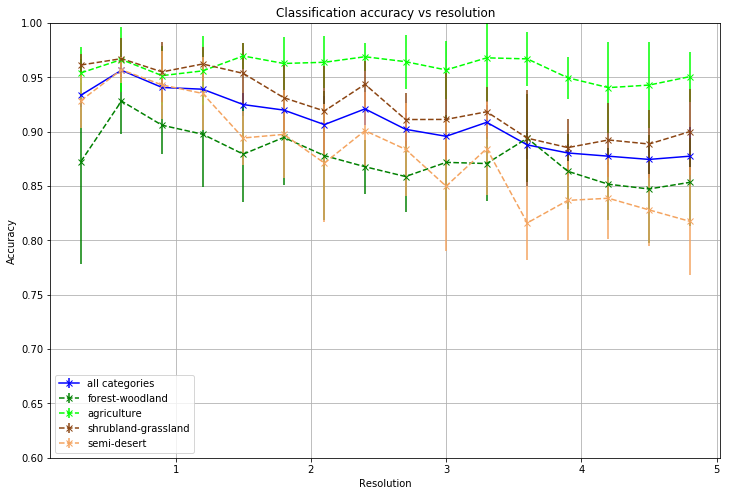

In [0]:
ACC_THRESHOLD = 0.6

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

grouped_results = load_grouped_results(PATH_RESULTS_RES, ACC_THRESHOLD)

ax.errorbar(
    grouped_results["resolution"], grouped_results["accuracy"]["mean"], grouped_results["accuracy"]["std"],
    #linestyle='dashed', 
    marker='x', 
    color=CATEGORY_COLOR["all"],
    label="all categories"
) 

for cat in CATEGORIES:
    acc = "accuracy_"+cat
    ax.errorbar(
        grouped_results["resolution"], grouped_results[acc]["mean"], grouped_results[acc]["std"],
        linestyle='dashed', 
        marker='x', 
        color=CATEGORY_COLOR[cat],
        label=cat
    ) 

ax.set(
    xlabel="Resolution",
    ylabel="Accuracy",
    title = "Classification accuracy vs resolution",
    ylim=(0.6,1)
)
ax.grid()
ax.legend()

plt.show()